In [1]:
import sys, os 
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))

# @title Imports
import dataclasses
import datetime
import functools
import math
import re
from typing import Optional
from glob import glob

import cartopy.crs as ccrs
#from google.cloud import storage
from wofscast import autoregressive
from wofscast import casting
from wofscast import checkpoint
from wofscast import data_utils
from wofscast import my_graphcast as graphcast
from wofscast import normalization
from wofscast import rollout
from wofscast import xarray_jax
from wofscast import xarray_tree
from IPython.display import HTML
import ipywidgets as widgets
import haiku as hk
import jax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import pandas as pd
import xarray #as xr
from wofscast.data_generator import to_static_vars, add_local_solar_time, wofscast_data_generator

# For training the weights!
import optax

from wofscast.utils import count_total_parameters, save_model_params, load_model_params 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
def construct_wrapped_graphcast(model_config: graphcast.ModelConfig, 
                                task_config: graphcast.TaskConfig,
                                #norm_stats: dict
                               ):
    """Constructs and wraps the GraphCast Predictor."""
    # Deeper one-step predictor.
    predictor = graphcast.GraphCast(model_config, task_config)

    # Modify inputs/outputs to `graphcast.GraphCast` to handle conversion to
    # from/to float32 to/from BFloat16.
    predictor = casting.Bfloat16Cast(predictor)

    # Modify inputs/outputs to `casting.Bfloat16Cast` so the casting to/from
    # BFloat16 happens after applying normalization to the inputs/targets.
    predictor = normalization.InputsAndResiduals(
      predictor,
     diffs_stddev_by_level=diffs_stddev_by_level,
      mean_by_level=mean_by_level,
      stddev_by_level=stddev_by_level
    )

    # Wraps everything so the one-step model can produce trajectories.
    predictor = autoregressive.Predictor(predictor, gradient_checkpointing=True)
    
    return predictor


@hk.transform_with_state
def run_forward(model_config, task_config, inputs, targets_template, forcings):
    predictor = construct_wrapped_graphcast(model_config, task_config)
    return predictor(inputs, targets_template=targets_template, forcings=forcings)


# Our models aren't stateful, so the state is always empty, so just return the
# predictions. This is requiredy by our rollout code, and generally simpler.
def drop_state(fn):
  return lambda **kw: fn(**kw)[0]

# Always pass params and state, so the usage below are simpler
def with_params(fn):
  return functools.partial(fn, params=model.model_params, state=model.state)

# Jax doesn't seem to like passing configs as args through the jit. Passing it
# in via partial (instead of capture by closure) forces jax to invalidate the
# jit cache if you change configs.
def with_configs(fn):
    return functools.partial(
      fn, model_config=model.model_config, task_config=model.task_config)

class WoFSCastRunner:
    def __init__(self, model_path, 
                 total_forward_time_minutes = '60min', 
                 timestep_minutes = '10min',
                 norm_stats_path = '/work/mflora/wofs-cast-data/normalization_stats', 
                 domain_size = None
                ):
        
        model_data = self.load_model(model_path)
        self.timestep_minutes = timestep_minutes
        self.n_timesteps = int(total_forward_time_minutes.split('min')[0]) // int(timestep_minutes.split('min')[0])
        self.domain_size = domain_size
    
        self.train_lead_times = slice(timestep_minutes, total_forward_time_minutes)
    
        self.model_params = model_data['parameters']
        self.state = {}
        self._init_task_config(model_data['task_config'])
        self._init_model_config(model_data['model_config'])

        self._load_norm_stats(norm_stats_path)
        
    def predict(self, inputs, targets, forcings): 

        #dataset = add_local_solar_time(dataset)
        
        #inputs, targets, forcings = data_utils.extract_inputs_targets_forcings(
        #        dataset, target_lead_times=self.train_lead_times,
        #        **dataclasses.asdict(self.task_config))
        
        #inputs = inputs.expand_dims(dim='batch', axis=0)
        #targets = targets.expand_dims(dim='batch', axis=0)
        #forcings = forcings.expand_dims(dim='batch', axis=0)
                
        # Convert the constant fields to time-independent (drop time dim)
        inputs = to_static_vars(inputs)

        # It is crucial to tranpose the data so that level is last 
        # since the input includes 2D & 3D variables. 
        inputs = self._transpose(inputs, ['batch', 'time', 'lat', 'lon', 'level'])
        targets = self._transpose(targets, ['batch', 'time', 'lat', 'lon', 'level'])
        forcings = self._transpose(forcings, ['batch', 'time', 'lat', 'lon'])
        
        #targets_template = self.expand_time_dim(targets) * np.nan
        targets_template = targets * np.nan
        
        print("Inputs:           ", inputs.dims.mapping)
        print("Target Template:  ", targets_template.dims.mapping)
        print("Forcings:         ", forcings.dims.mapping)
        
        run_forward_jitted = drop_state(with_params(jax.jit(with_configs(
            run_forward.apply))))

        # @title Autoregressive rollout (keep the loop in JAX)
        predictions = rollout.chunked_prediction(
            run_forward_jitted,
            rng=jax.random.PRNGKey(0),
            inputs=inputs,
            targets_template=targets_template,
            forcings=forcings)

        return predictions #, targets, inputs
        
    def _transpose(self, ds, dims):
        return ds.transpose(*dims, missing_dims='ignore')    
    
    def expand_time_dim(self, ds, forcings=False):
        # Repeat the time dimension n_timesteps number of times 
        # Use isel to select the slice and tile to repeat it
        repeated_slices = [ds.isel(time=0)] * self.n_timesteps
    
        # Concatenate the repeated slices along the 'time' dimension
        expanded_ds = xarray.concat(repeated_slices, dim='time')

        # Add a new datetime for the forcing variables. 
        # Generate the datetime range. 
        if forcings: 
            start_time = ds.datetime[0].values
            time_range = pd.date_range(start=start_time, periods=self.n_timesteps, freq=self.timestep_minutes)
            expanded_ds['time'] = time_range
            expanded_ds = expanded_ds.assign_coords(datetime=time_range)

            # Convert 'time' dimension to timedeltas from the first time point
            time_deltas = (expanded_ds['time'] - expanded_ds['time'][0]).astype('timedelta64[ns]')
            expanded_ds['time'] = time_deltas

        expanded_ds = self._transpose(expanded_ds, ['batch', 'time', 'lat', 'lon', 'level', 'datetime'])
    
        return expanded_ds

    
    # Load the model 
    def load_model(self, path):
        with open(path, 'rb') as f:
            data = checkpoint.load(f, dict)
    
        #Unravel the task config. 
        _TASK_CONFIG_KEYS = list(vars(graphcast.TaskConfig)['__dataclass_fields__'].keys())
    
        task_config = data['task_config']
    
        task_config_dict = {}
        for key in _TASK_CONFIG_KEYS: 
            if isinstance(task_config[key], dict):
                # unravel
                if key == 'pressure_levels':
                    task_config_dict[key] = [int(item) for _, item in task_config[key].items()]
                else:
                    task_config_dict[key] = [str(item) for _, item in task_config[key].items()]
            elif key == 'input_duration':
                task_config_dict[key] = str(task_config[key])
            else:
                task_config_dict[key] = task_config[key]
    
    
        data['task_config'] = task_config_dict
    
        return data 
    
    def _init_task_config(self, data): 

        domain_size =self.domain_size if self.domain_size else data['domain_size']
        
        self.task_config = graphcast.TaskConfig(
              input_variables=data['input_variables'],
              target_variables=data['target_variables'],
              forcing_variables=data['forcing_variables'],
              pressure_levels=data['pressure_levels'],
              input_duration=data['input_duration'],
              n_vars_2D = data['n_vars_2D'],
              domain_size = domain_size
          )
    
    def _init_model_config(self, data):
        self.model_config = graphcast.ModelConfig(
              resolution=int(data['resolution']),
              mesh_size=int(data['mesh_size']),
              latent_size=int(data['latent_size']),
              gnn_msg_steps=int(data['gnn_msg_steps']),
              hidden_layers=int(data['hidden_layers']),
              grid_to_mesh_node_dist=int(data['grid_to_mesh_node_dist']),
              loss_weights = data['loss_weights'],
        )
    
    def _load_norm_stats(self, path):     
        mean_by_level = xarray.load_dataset(os.path.join(path, 'mean_by_level.nc'))
        stddev_by_level = xarray.load_dataset(os.path.join(path, 'stddev_by_level.nc'))
        diffs_stddev_by_level = xarray.load_dataset(os.path.join(path, 'diffs_stddev_by_level.nc'))

        self.norm_stats = {'mean_by_level': mean_by_level, 
                      'stddev_by_level' : stddev_by_level,
                      'diffs_stddev_by_level' : diffs_stddev_by_level
                     }


## Predict with WoFS-Cast

In [4]:
%%time 
# 256 samples, ~32 GB; ~ 6 min loading time. 

in_path = '/work/mflora/wofs-cast-data/eval_datasets'
inputs = xarray.load_dataset(os.path.join(in_path, 'eval_inputs.nc'))
targets = xarray.load_dataset(os.path.join(in_path, 'eval_targets.nc'))
forcings = xarray.load_dataset(os.path.join(in_path, 'eval_forcings.nc'))

CPU times: user 2min 40s, sys: 16.2 s, total: 2min 56s
Wall time: 3min 50s


In [5]:
model = WoFSCastRunner('/work/mflora/wofs-cast-data/model/wofscast_baseline_v1.npz', 
                       total_forward_time_minutes = '120min'
                      )
mean_by_level = model.norm_stats['mean_by_level']
stddev_by_level = model.norm_stats['stddev_by_level']
diffs_stddev_by_level = model.norm_stats['diffs_stddev_by_level']


## Batch process the evaluation dataset 

In [8]:
all_predictions = [] 

n_timesteps = 12
# Batch like this is neccesary to not overload the GPU! 
n=0
for batch_inputs, batch_targets, batch_forcings in wofscast_data_generator(
                                                                    inputs, 
                                                                    targets, 
                                                                    forcings,                
                                                                    batch_size = 8, 
                                                                    n_timesteps=n_timesteps
                                                                              ):
    
    predictions = model.predict(batch_inputs, batch_targets, batch_forcings)
    all_predictions.append(predictions)
    n+=1
    print(f'Batch : {n}')
    
predictions = xarray.concat(all_predictions, dim='batch')

Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 1


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 2


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 3
Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}


Batch : 4


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 5


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 6


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 7


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 8


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 9


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 10


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 11


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 12


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 13


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 14


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 15


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 16


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 17


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 18


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 19


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 20


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 21


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 22


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 23


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 24


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 25


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 26


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 27


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 28


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 29


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 30


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 31


Inputs:            {'batch': 8, 'time': 2, 'level': 17, 'lat': 150, 'lon': 150}
Target Template:   {'lat': 150, 'lon': 150, 'time': 12, 'level': 17, 'batch': 8}
Forcings:          {'batch': 8, 'time': 12, 'lon': 150, 'lat': 150}
Batch : 32


NameError: name 'xr' is not defined

In [10]:
target_vars = ['T', 'QVAPOR', 'T2',
               'U', 'V', 'W',
               'GEOPOT', 'RAIN_AMOUNT', 'COMPOSITE_REFL_10CM'] 

units = ['K', 'kg/kg', 'K', 
         r'm s$^{-1}$', r'm s$^{-1}$', r'm s$^{-1}$', 
         'm', 'mm', 'dBZ'
        ]

display_name = {'T': 'Potential\nTemperature', 
                'QVAPOR': 'Water Vapor Mixing Ratio', 
                'T2': '2-m Temperature', 
                'U': 'U-wind comp.', 
                'V': 'V-wind comp.', 
                'W': 'W-wind comp.', 
                'GEOPOT': 'Geopotential Height', 
                'RAIN_AMOUNT': 'Rain Rate', 
                'COMPOSITE_REFL_10CM': 'Composite Refl.'
               }

## Time Series of RMSE for the Target Variables.

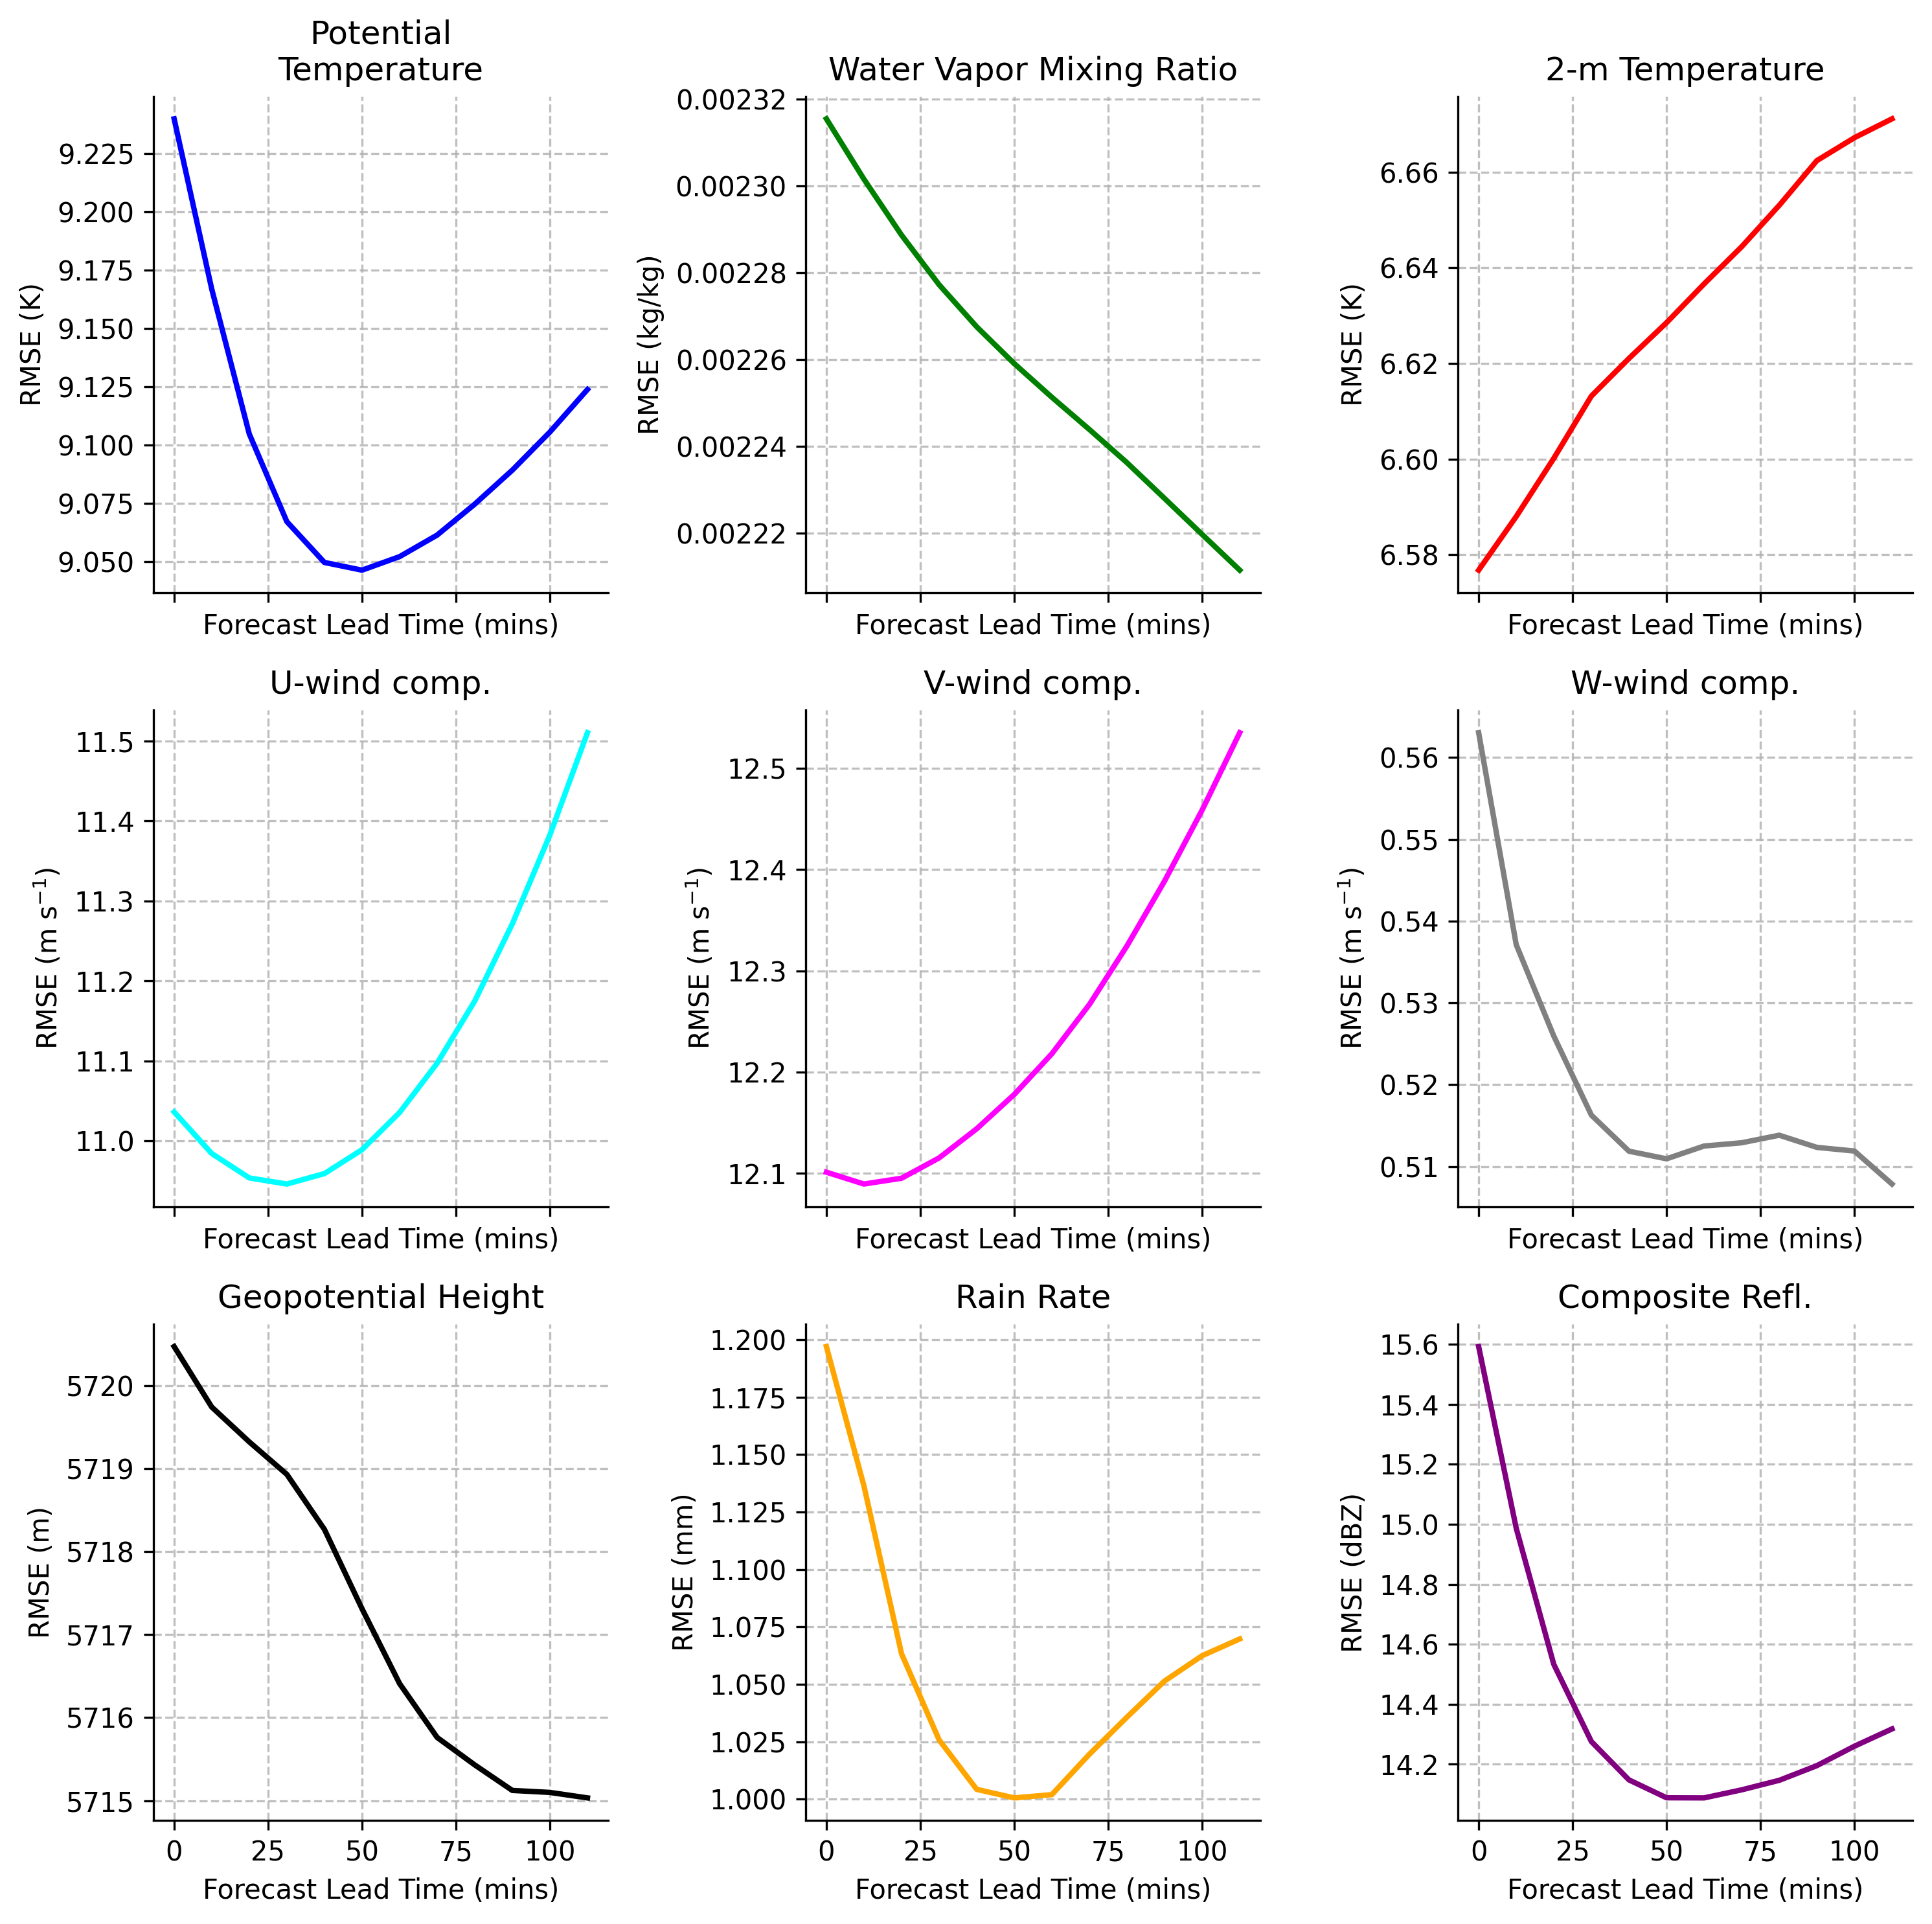

In [11]:
def _mean_preserving_time(x: xarray.DataArray) -> xarray.DataArray:
    return x.mean([d for d in x.dims if d != 'time'], skipna=False)


predictions = predictions.transpose('batch', 'time', 'level', 'lat', 'lon')
times = np.arange(len(predictions.time))*10 # in minutes 
fig, axes = plt.subplots(figsize=(10,10), dpi=300, ncols=3, nrows=3, sharex=True)

# Create a list of colors for each line
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'gray', 'black', 'orange', 'purple']

for var, unit, ax, c in zip(target_vars, units, axes.flat, colors): 
    
    err = (predictions[var]-targets[var])**2
    rmse = np.sqrt(_mean_preserving_time(err))

    ax.plot(times, rmse, c=c, lw=2.0) 

    ax.set(xlabel= 'Forecast Lead Time (mins)', 
       ylabel= f'RMSE ({unit})', 
       title = display_name[var]
      )
    ax.grid(ls='dashed', alpha=0.8)
    # Hide the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.tight_layout()

## Time Series of MAPE (Mean Absolute Percent Error) 

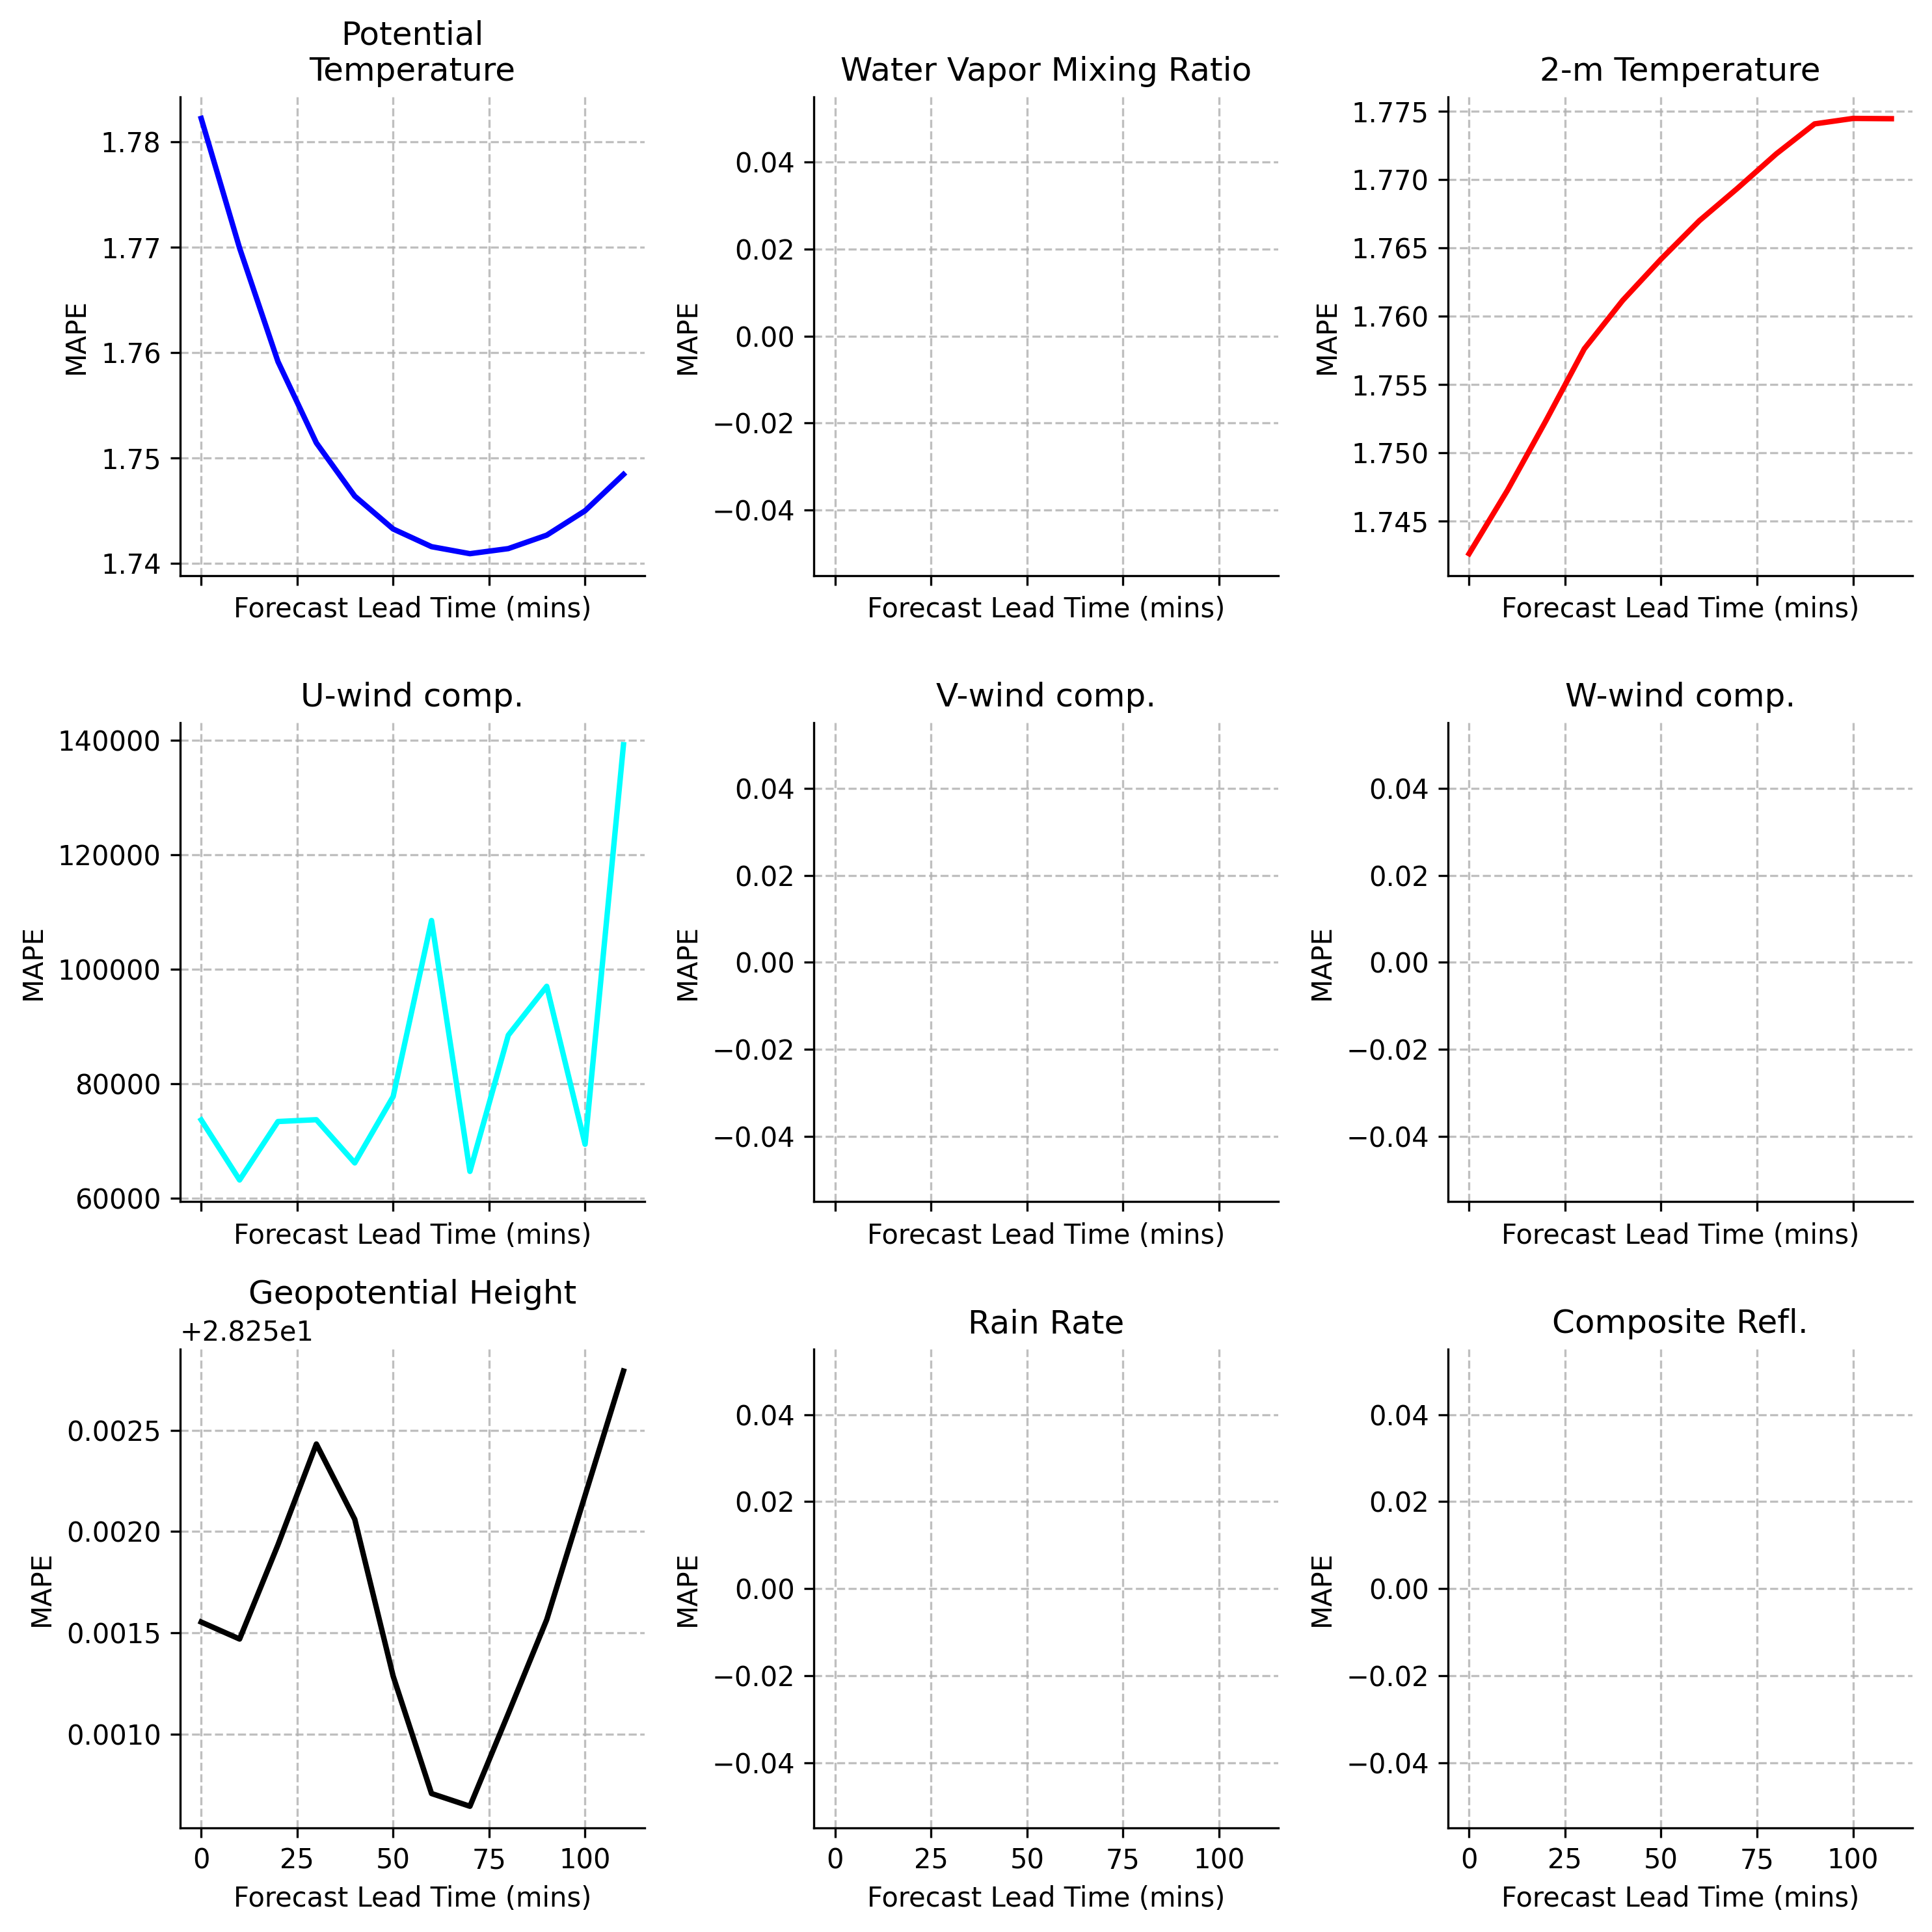

In [12]:
predictions = predictions.transpose('batch', 'time', 'level', 'lat', 'lon')
times = np.arange(len(predictions.time))*10 # in minutes 
fig, axes = plt.subplots(figsize=(10,10), dpi=300, ncols=3, nrows=3, sharex=True)

# Create a list of colors for each line
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'gray', 'black', 'orange', 'purple']

for var, unit, ax, c in zip(target_vars, units, axes.flat, colors): 
    
    # Compute absolute percentage error
    ape = abs((predictions[var] - targets[var]) / targets[var]) * 100
    
    mape = _mean_preserving_time(ape)

    ax.plot(times, mape, c=c, lw=2.0) 

    ax.set(xlabel= 'Forecast Lead Time (mins)', 
       ylabel= f'MAPE', 
       title = display_name[var]
      )
    ax.grid(ls='dashed', alpha=0.8)
    # Hide the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.tight_layout()

## Time-Height of the Differences 

In [ ]:
def _mean_preserving_level_and_time(x: xarray.DataArray) -> xarray.DataArray:
    return x.mean([d for d in x.dims if d not in ['time', 'level']], skipna=False)

target_vars_level = ['T','QVAPOR', 'GEOPOT', 
                     'U', 'V', 'W' ] 
predictions = predictions.transpose('batch', 'time', 'level', 'lat', 'lon')

fig, axes = plt.subplots(figsize=(10,5), dpi=300, ncols=3, nrows=2, sharex=True, sharey=True)

for var,  ax in zip(target_vars_level, axes.flat): 
    diff = _mean_preserving_level_and_time((predictions[var]-targets[var]))
    vmax = np.max(diff)
    vmin = -vmax 
    
    cm = ax.pcolormesh(diff.T, vmax=vmax, vmin=vmin, cmap='seismic', alpha=0.85)     
    ax.set(xlabel= 'Time', 
       ylabel= f'Level', 
       title = f'{display_name[var]} ({unit})'
      )
    #plt.colorbar(cm, ax=ax)
plt.tight_layout()

# TODO: 

1. Object Matching 
